<a href="https://colab.research.google.com/github/ahmadryan/COVID19hackathon/blob/master/air_quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Air quality

### Here we read in data from the Department of Natural Resources and Environmental Control (DNREC) Air Quality Monitoring Network and make some basic plots.

#### <a href="https://data.delaware.gov/Energy-and-Environment/Air-Quality-Monitoring-Network/b6hy-ss9q">Dataset access from Delaware Open Data</a>

#### <a href="https://airmonitoring.dnrec.delaware.gov/">Map of monitoring stations</a>  with description and photograph of each site

<p>The raw dataset has lots of missing measurements from when sensors were not functioning. Sometimes these are labeled <tt>NoData</tt> or <tt>Down</tt> in the <tt>STT_DataStatusCodeText</tt> column of the <tt>csv</tt> file you download from the web. In other places, invalid data is marked by -9999 in the <tt>ParamValue</tt> column. I downloaded the dataset on Tuesday, May 5 and used the <tt>UNIX</tt> shell to remove invalid values:<br />
    <tt>cat Air_Quality.csv | grep -v NoData | grep -v Down | grep -v "\-9999" > Air_Quality_valid.csv</tt><br />
This cuts the size of the <tt>.csv</tt> file by a third. If you want to download a more recent version of the dataset, I suggest trimming the invalid values in the <tt>UNIX</tt> shell rather than dealing with them in <tt>python</tt>. Finally, you can <tt>gzip</tt> the file to cut its size by another factor of 10:<br />
<tt>gzip Air_Quality_valid.csv</tt></p>

#### Set up <tt>python</tt> environment and read in the data using <tt>pandas</tt>:

In [1]:
from google.colab import drive

drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
cd gdrive/My\ Drive/

/content/gdrive/My Drive


In [3]:
cd hackathon2020/

/content/gdrive/My Drive/hackathon2020


In [4]:
import tensorflow as tf
import pylab as pl
from sklearn import preprocessing
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error
import math
import os
import xlrd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from statsmodels.tsa.stattools import adfuller
import pathlib
import seaborn as sns
from numpy import *
import pandas as pd

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
df = pd.read_csv('Air_Quality_valid.csv', parse_dates=["Date_Time"])

In [6]:
df.keys()

Index(['Date_Time', 'CountyCode', 'STA_StationName', 'MOT_AIR_ParamCode',
       'MOT_MonitorName', 'ParamValue', 'STT_DataStatusCodeText'],
      dtype='object')

In [7]:
df['STA_StationName'].unique()

array(['Martin Luther King', 'Brandywine Creek State Park',
       'Bellefonte II', 'Lums Pond State Park', 'Rt #9-Delaware City',
       'Killens Pond', 'Seaford', 'Lewes'], dtype=object)

In [0]:
# -- get a subset of the columns
cols = ["Date_Time", "MOT_MonitorName", "ParamValue"]
lewes_sub = df[df["STA_StationName"] == "Lewes"][cols].copy()
mlk_sub = df[df["STA_StationName"] == "Martin Luther King"][cols].copy()
#seaford_sub = df[df["STA_StationName"] == "Seaford"][cols].copy()

In [0]:
dcity_sub = df[df["STA_StationName"] == "Rt #9-Delaware City"][cols].copy()

In [0]:
# Subgroups and unstacking

lewes_subg = lewes_sub.groupby(["Date_Time", "MOT_MonitorName"]).mean().unstack("MOT_MonitorName")["ParamValue"]
mlk_subg = mlk_sub.groupby(["Date_Time", "MOT_MonitorName"]).mean().unstack("MOT_MonitorName")["ParamValue"]
#seaford_subg = seaford_sub.groupby(["Date_Time", "MOT_MonitorName"]).mean().unstack("MOT_MonitorName")["ParamValue"]
dcity_subg = dcity_sub.groupby(["Date_Time", "MOT_MonitorName"]).mean().unstack("MOT_MonitorName")["ParamValue"]

In [15]:
dcity_subg

MOT_MonitorName,CO,PM 2.5 TAPI,PM2.5 5030i IN,RH,SO2 Trace Level,SO2-Max5min,Temp,Wind Dir V,Wind Speed V
Date_Time,,,,,,,,,
2011-03-30 12:00:00,NaN,NaN,NaN,NaN,NaN,286.980000,NaN,NaN,NaN
2011-03-30 13:00:00,NaN,NaN,NaN,NaN,NaN,1.533533,NaN,NaN,NaN
2011-03-30 14:00:00,NaN,NaN,NaN,NaN,NaN,2.891000,NaN,NaN,NaN
2011-03-30 15:00:00,NaN,NaN,NaN,NaN,NaN,1.722467,NaN,NaN,NaN
2011-03-30 16:00:00,NaN,NaN,NaN,NaN,NaN,1.099420,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2020-05-05 14:00:00,NaN,7.134276,NaN,41.63945,0.162419,0.265100,57.45306,270.1961,3.072901
2020-05-05 15:00:00,NaN,7.827504,NaN,38.77274,0.231978,0.490200,58.20195,253.6011,3.717314
2020-05-05 16:00:00,NaN,7.264303,NaN,42.18387,0.175443,0.224500,58.75178,252.4284,3.767852


In [0]:
# Select only a few columns which will go in NN as input
lewes_short = lewes_subg[['RH', 'SO2-Max5min', 'Temp', 'Wind Dir V', 'Wind Speed V']]
mlk_short = mlk_subg[['RH', 'SO2-Max5min', 'Temp', 'Wind Dir V', 'Wind Speed V']]
#seaford_short = seaforf_resampled.drop(['NO2', 'NOX', 'Ozone', 'SO2-Max5min'], axis=1)
dcity_short = dcity_subg.drop(['CO', 'PM 2.5 TAPI', 'RH', 'SO2-Max5min', 'CO', 'Temp', 'Wind Dir V', 'Wind Speed V'], axis=1)

In [19]:
mlk_short.head()

MOT_MonitorName,RH,SO2-Max5min,Temp,Wind Dir V,Wind Speed V
Date_Time,,,,,
2010-11-15 17:00:00,NaN,NaN,12.39444,NaN,NaN
2010-11-15 18:00:00,NaN,NaN,12.22639,NaN,NaN
2010-11-15 19:00:00,NaN,NaN,12.03083,NaN,NaN
2010-11-15 20:00:00,NaN,NaN,11.41194,NaN,NaN
2010-11-15 21:00:00,NaN,NaN,10.60222,NaN,NaN


In [0]:
# resample the whole dataset

def nanmeanfun(x):
    return nanmean(x)

lewes_resampled = lewes_short.resample('1H').apply(nanmean)
mlk_resampled = mlk_short.resample('1H').apply(nanmean)
dcity_resampled = dcity_short.resample('1H').apply(nanmean)
#seaford_resampled = seaford_subg.resample('1H').apply(nanmean)

In [21]:
print(lewes_resampled.shape), print(mlk_resampled.shape)
lewes_cleaned = lewes_resampled.dropna()
mlk_cleaned = mlk_resampled.dropna()
dcity_cleaned = dcity_resampled.dropna()
print(lewes_cleaned.shape), print(mlk_cleaned.shape);

(79433, 5)
(83018, 5)
(64248, 5)
(66153, 5)


In [0]:
lewes_scaled = pd.DataFrame()
mlk_scaled = pd.DataFrame()
lewes_array = preprocessing.minmax_scale(lewes_cleaned)
mlk_array = preprocessing.minmax_scale(mlk_cleaned)
for i,key in enumerate(mlk_resampled.keys()) :
    lewes_scaled[key] = lewes_array[:,i]
    mlk_scaled[key] = mlk_array[:,i]
#mlk_scaled['SO2-Max5min'] = temp_array[:,1]
#mlk_scaled['Temp'] = temp_array[:,2]
#mlk_scaled['Wind Dir V'] = temp_array[:,3]
#mlk_scaled['Wind Speed V'] = temp_array[:,4]

In [23]:
lewes_scaled.shape

(64248, 5)

## Neural Netwrok

In [0]:
lewes_train = lewes_scaled.copy()
lewes_test = lewes_scaled.copy()

In [0]:
trX = lewes_train.iloc[:40000, ]
trY = trX["SO2-Max5min"]
trX = trX.drop(["SO2-Max5min"], axis=1)
valX = lewes_test.iloc[40010:50000,]
valY = valX["SO2-Max5min"]
valX = valX.drop(["SO2-Max5min"], axis=1)
teX = lewes_test.iloc[50010:,]
teY = teX["SO2-Max5min"]
teX = teX.drop(["SO2-Max5min"], axis=1)

In [28]:
lewes_test.iloc[50010:50020]

,RH,SO2-Max5min,Temp,Wind Dir V,Wind Speed V
50010,0.883427,0.004349,0.496203,0.535876,0.141490
50011,0.865160,0.004488,0.492333,0.546058,0.144232
50012,0.883124,0.003719,0.487968,0.562799,0.130716
50013,0.893572,0.003287,0.484670,0.542570,0.142319
50014,0.899676,0.003602,0.481344,0.554426,0.115399
50015,0.915903,0.003193,0.477585,0.541000,0.100531
50016,0.935384,0.003107,0.474949,0.531814,0.098554
50017,0.943414,0.003202,0.472683,0.491365,0.096403
50018,0.946857,0.003049,0.472905,0.526100,0.097370
50019,0.923884,0.003130,0.485248,0.515104,0.100838


In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(42, activation="tanh", kernel_initializer='he_uniform'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(40, activation="tanh", kernel_initializer='he_uniform'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(37, activation="tanh", kernel_initializer='he_uniform'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(33, activation="tanh", kernel_initializer='he_uniform'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(30, activation="tanh", kernel_initializer='he_uniform'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(25, activation="tanh", kernel_initializer='he_uniform'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(20, activation="tanh", kernel_initializer='he_uniform'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(10, activation="tanh", kernel_initializer='he_uniform'),
    tf.keras.layers.Dense(5, activation="tanh", kernel_initializer='he_uniform'),
    tf.keras.layers.Dense(1)])

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(40, activation="tanh", kernel_initializer='he_uniform'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(40, activation="tanh", kernel_initializer='he_uniform'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(30, activation="tanh", kernel_initializer='he_uniform'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(25, activation="tanh", kernel_initializer='he_uniform'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(36, activation="tanh", kernel_initializer='he_uniform'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(40, activation="tanh", kernel_initializer='he_uniform'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(55, activation="tanh", kernel_initializer='he_uniform'),
    tf.keras.layers.Dropout(0.1),
    #tf.keras.layers.Dense(1, activation="tanh", kernel_initializer='he_uniform'),
    tf.keras.layers.Dense(1)])

In [0]:
yes = tf.keras.callbacks.EarlyStopping(min_delta = 0, verbose=1, 
                                       patience=100, mode="min", restore_best_weights=True)

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
                  loss='mse')

In [58]:
history = model.fit(trX.to_numpy(), trY.to_numpy(), verbose=1, validation_data=(valX.to_numpy(), valY.to_numpy()), 
                 epochs=300, batch_size=48, callbacks=[yes])

Epoch 1/300
834/834 [==============================] - 3s 3ms/step - loss: 0.0866 - val_loss: 5.8901e-04
Epoch 2/300
834/834 [==============================] - 3s 3ms/step - loss: 0.0139 - val_loss: 1.4984e-05
Epoch 3/300
834/834 [==============================] - 2s 3ms/step - loss: 0.0053 - val_loss: 1.8964e-05
Epoch 4/300
834/834 [==============================] - 3s 3ms/step - loss: 0.0018 - val_loss: 6.3743e-06
Epoch 5/300
834/834 [==============================] - 3s 3ms/step - loss: 4.7360e-04 - val_loss: 6.5250e-06
Epoch 6/300
834/834 [==============================] - 3s 3ms/step - loss: 9.6646e-05 - val_loss: 6.4634e-06
Epoch 7/300
834/834 [==============================] - 3s 3ms/step - loss: 3.7740e-05 - val_loss: 7.0804e-06
Epoch 8/300
834/834 [==============================] - 3s 3ms/step - loss: 3.4320e-05 - val_loss: 6.1782e-06
Epoch 9/300
834/834 [==============================] - 3s 3ms/step - loss: 3.4686e-05 - val_loss: 7.1088e-06
Epoch 10/300
834/834 [=============

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much

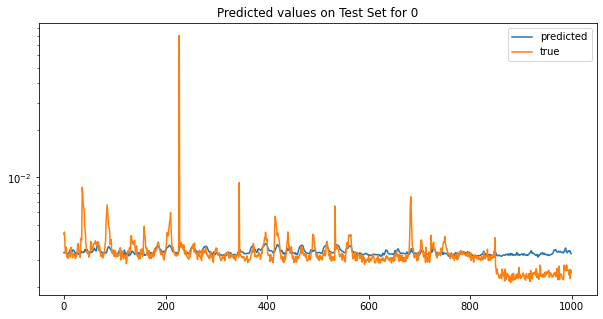

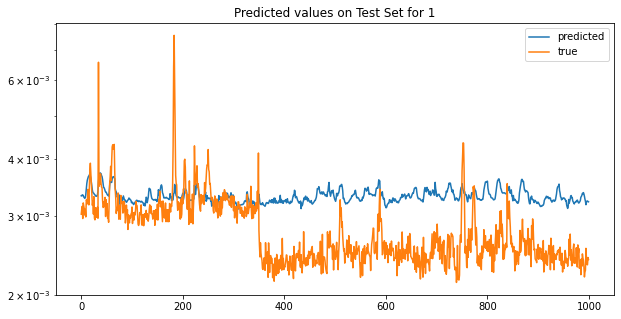

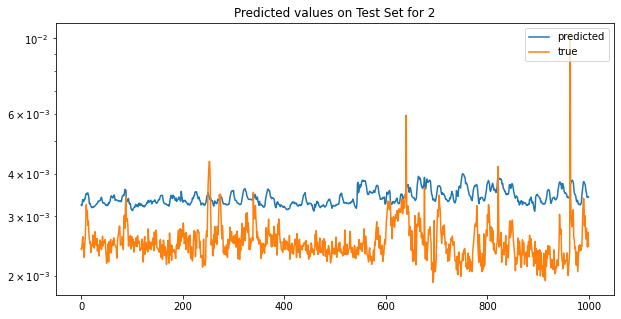

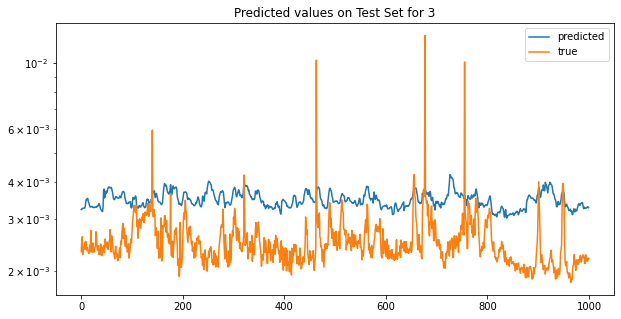

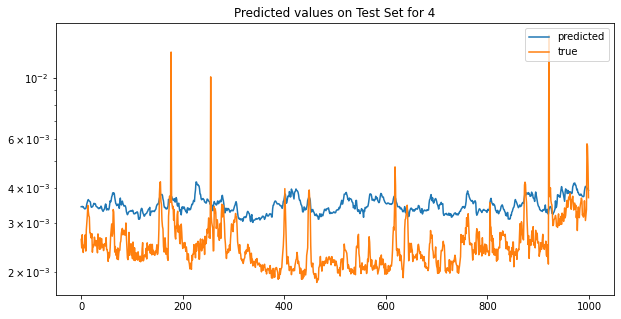

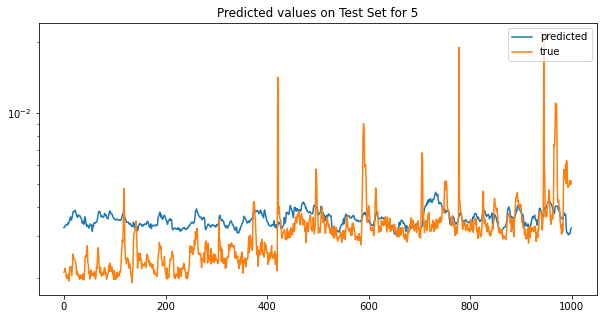

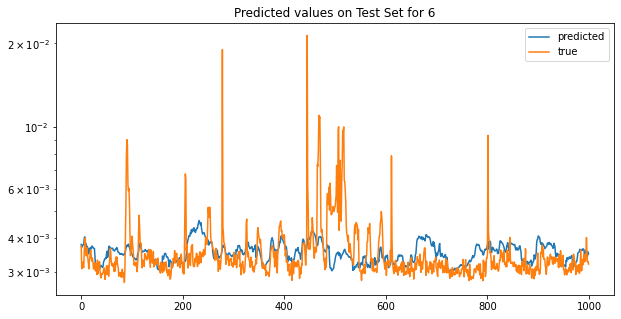

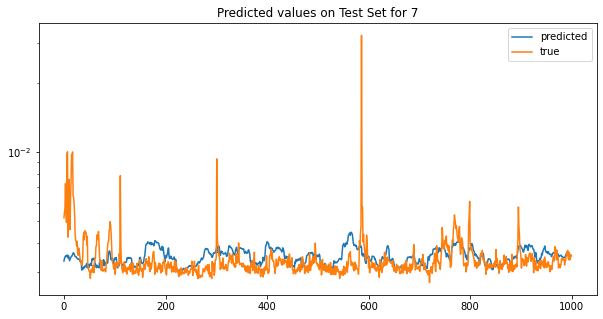

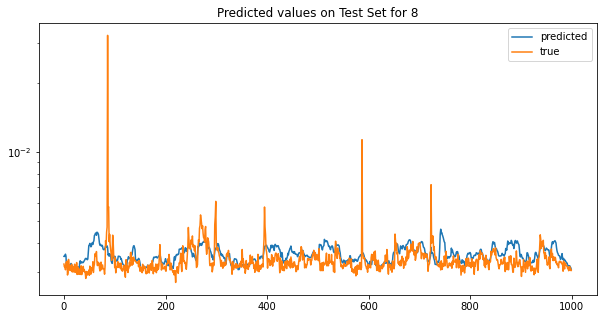

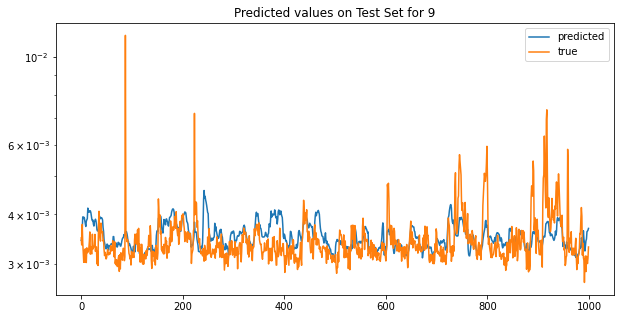

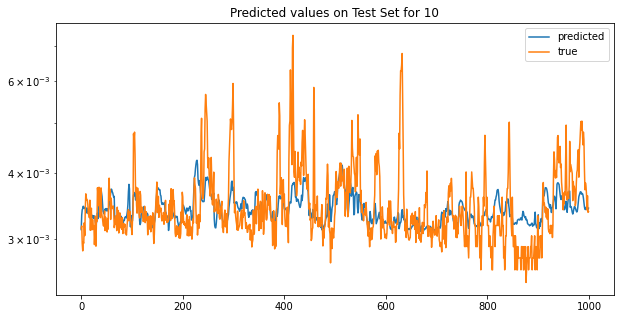

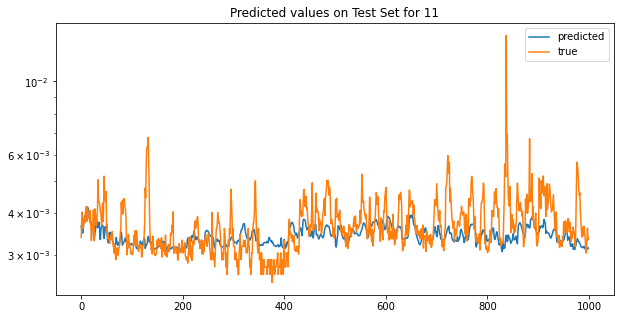

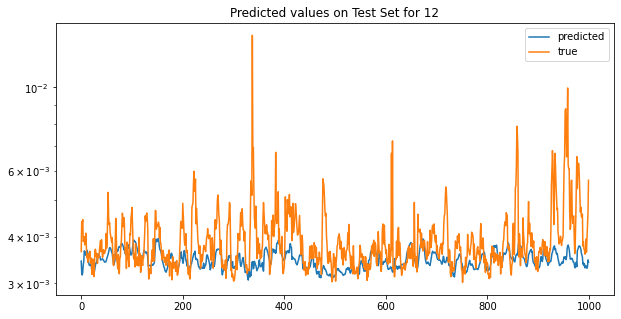

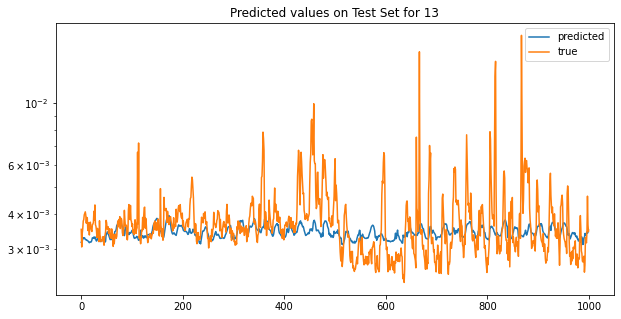

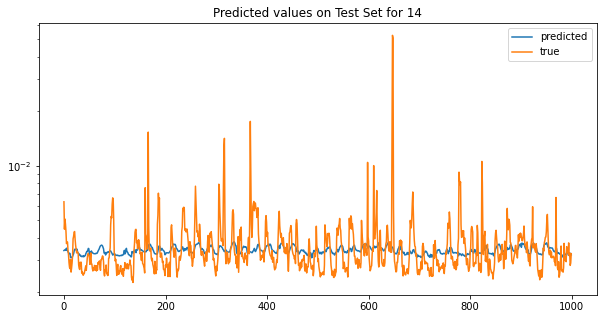

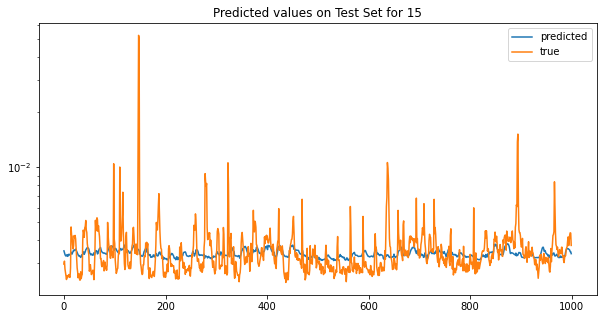

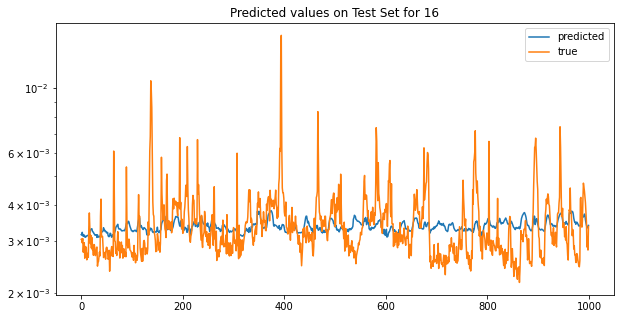

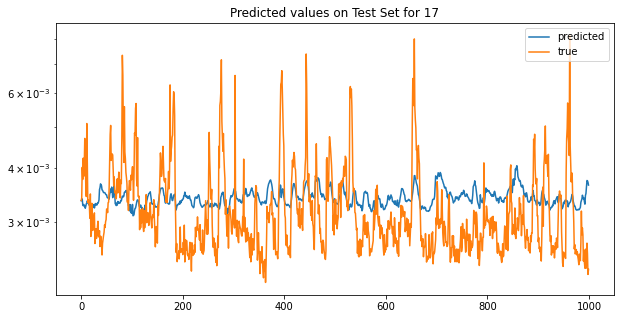

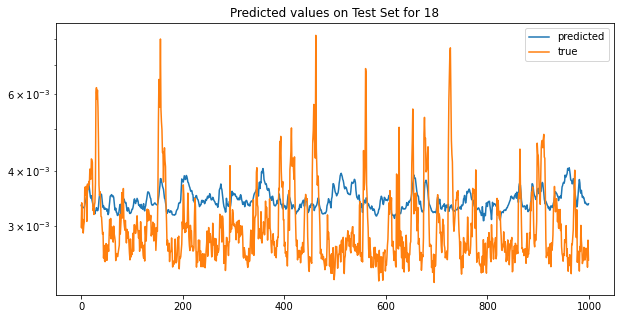

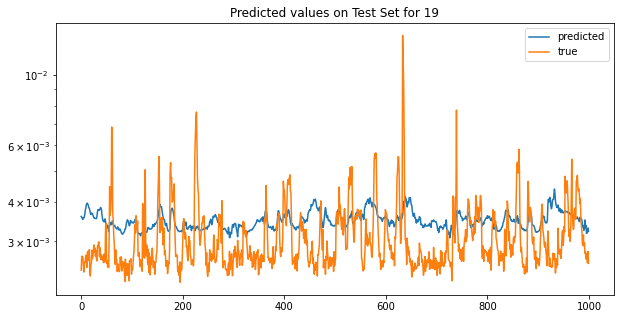

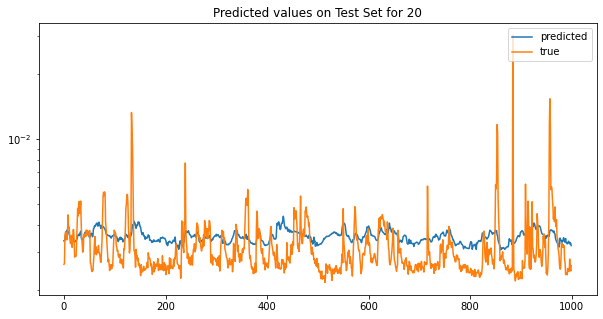

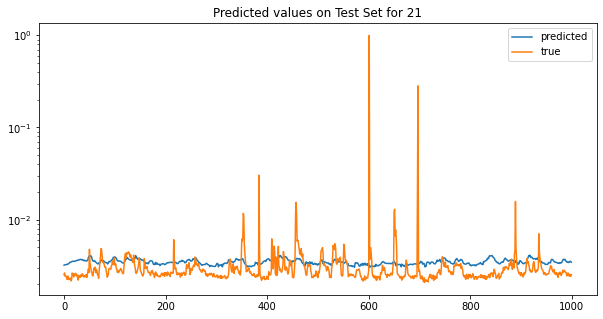

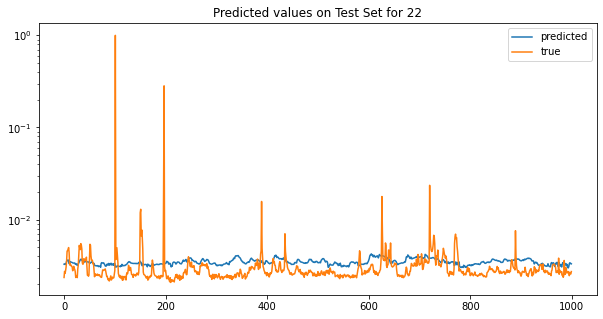

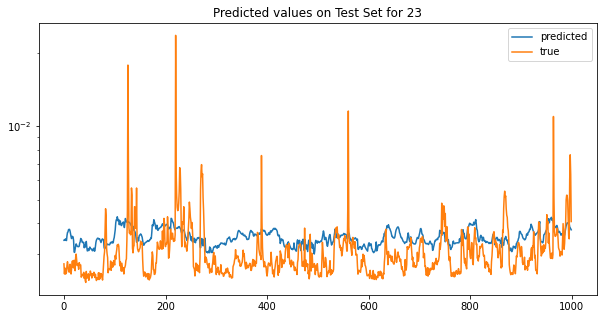

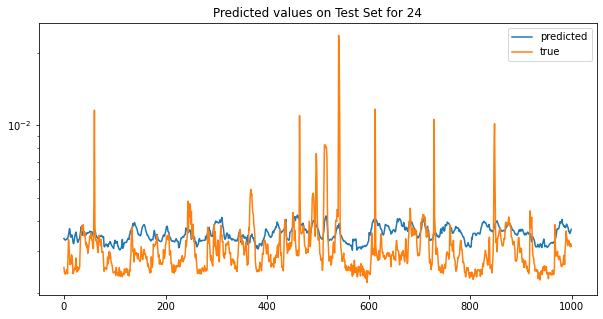

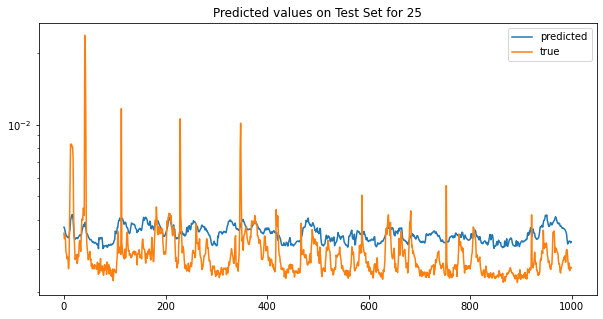

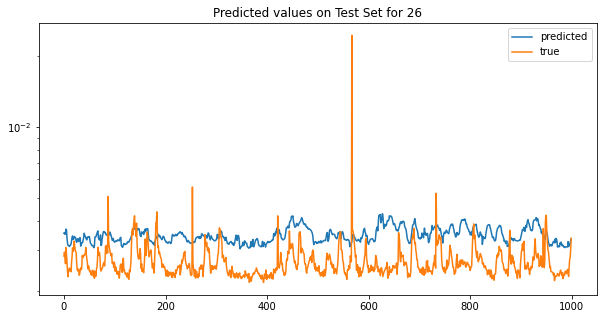

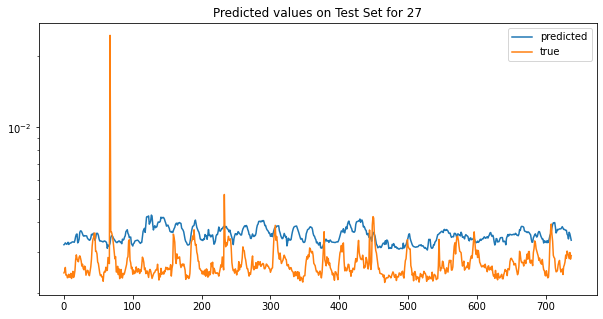

In [105]:
for i in range(28):
    ind1= i*500
    ind2=ind1 + 1000
    pl.figure(figsize=(10,5))
    predicted_value = model.predict(teX)[ind1:ind2]
    true_value = teY.values[ind1:ind2]
    pl.plot(predicted_value, label="predicted")
    #pl.plot(model.predict(teX)[3500:4500], label="predicted")
    pl.plot(true_value, label="true")
    pl.title("Predicted values on Test Set for %s"%(i))
    pl.legend(loc="upper right")
    pl.yscale('log')

In [106]:
ind2

14500

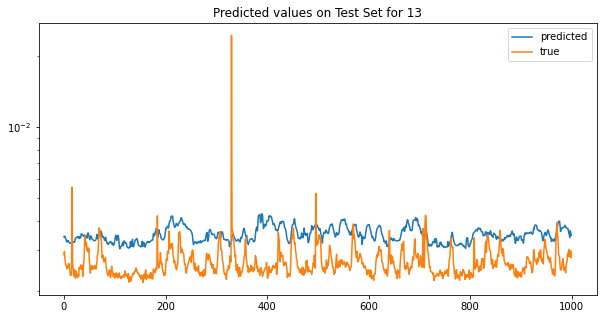

In [98]:
ind1= -1001
ind2=ind1 + 1000
pl.figure(figsize=(10,5))
predicted_value = model.predict(teX)[ind1:ind2]
true_value = teY.values[ind1:ind2]

pl.plot(predicted_value, label="predicted")
pl.plot(true_value, label="true")
pl.title("Predicted values on Test Set for %s"%(i))
pl.legend(loc="upper right")
pl.yscale('log')

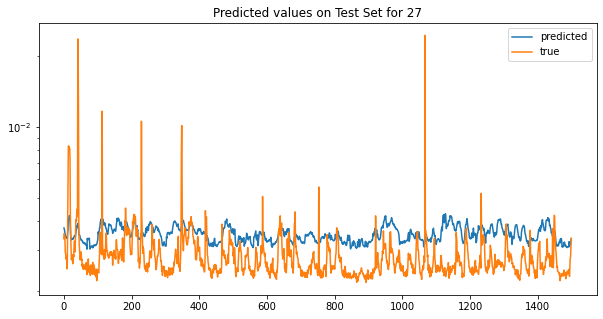

In [116]:
ind1= 12500
ind2=14000
pl.figure(figsize=(10,5))
predicted_value = model.predict(teX)[ind1:ind2]
true_value = teY.values[ind1:ind2]

pl.plot(predicted_value, label="predicted")
pl.plot(true_value, label="true")
pl.title("Predicted values on Test Set for %s"%(i))
pl.legend(loc="upper right")
pl.yscale('log')

In [95]:
len(teY)

14238

In [118]:
min(lewes_cleaned.index[12500:13500]), max(lewes_cleaned.index[12500:14000])

(Timestamp('2014-03-07 00:00:00'), Timestamp('2014-05-09 06:00:00'))

In [0]:
df_model = pd.DataFrame()
df_model['predicted'] = model.predict(teX)[:,0]
df_model['true_value'] = array(teY)

df_model.to_csv('model_predicted.csv')

In [76]:
array(teY)

array([0.00434855, 0.0044879 , 0.00371896, ..., 0.00297318, 0.00278705,
       0.00288488])

In [62]:
df_model

""


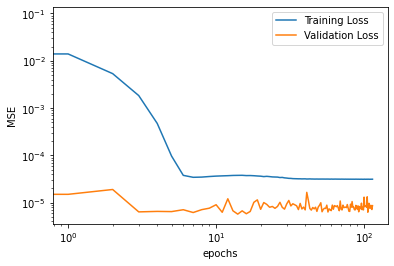

In [80]:
pl.plot(history.history["loss"], label="Training Loss")
pl.plot(history.history["val_loss"], label="Validation Loss")
pl.xlabel("epochs")
pl.ylabel("MSE")
pl.legend()
pl.yscale('log')
pl.xscale('log')

#for df, sl in zip(df_list,station_list) :

for i,mn in enumerate(monitorNames):
    print(mn)
    df_lewes[param_list[i]] = airdata[(airdata['STA_StationName'] == 'Lewes') & \
    (airdata['MOT_MonitorName'] == mn)]

In [129]:
type(df)

pandas.core.frame.DataFrame

In [127]:
param_list[i], mn

('aq_temp', 'AQS Temp Deg C')

In [0]:
Lewes = airdata[(airdata['STA_StationName'] == 'Lewes')]
Seaford = airdata[(airdata['STA_StationName'] == 'Seaford')]
MLK = airdata[(airdata['STA_StationName'] == 'Martin Luther King')]

In [99]:
Seaford.keys()

Index(['Date_Time', 'CountyCode', 'STA_StationName', 'MOT_AIR_ParamCode',
       'MOT_MonitorName', 'ParamValue', 'STT_DataStatusCodeText'],
      dtype='object')

In [0]:
wind_lewes_dir = Lewes.loc[Lewes['MOT_MonitorName']=='Wind Dir V']

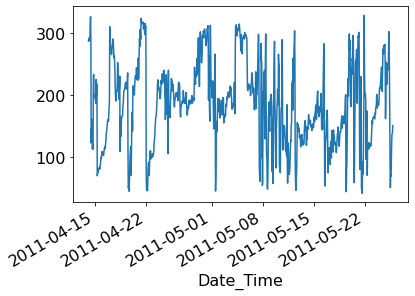

In [109]:
df_lewes = pd.DataFrame()

df_lewes['so2'] = Lewes.loc[Lewes['MOT_MonitorName']=='']
df_lewes['wind_vel'] = Lewes.loc[Lewes['MOT_MonitorName']=='Wind Speed V']
df_lewes['wind_dir'] = Lewes.loc[Lewes['MOT_MonitorName']=='Wind Dir V']

In [102]:
airdata['MOT_MonitorName'].unique()

array(['SO2 Trace Level', 'CO Trace Level', 'Temp', 'NOX', 'Ozone', 'NO2',
       'Wind Speed V', 'Wind Dir V', 'NOY', 'RH', 'BC',
       'PM2.5 Sharp Colo', 'SO2-Max5min', 'PM2.5 5030i IN',
       'AQS Temp Deg C', 'PM 2.5 TAPI', 'CO'], dtype=object)

In [94]:
plt.plot(Lewes['Wind Dir V'][-1000:], marker='.', ls=None)

KeyError: ignored

In [92]:
Lewes_SO2.keys()

Index(['Date_Time', 'CountyCode', 'STA_StationName', 'MOT_AIR_ParamCode',
       'MOT_MonitorName', 'ParamValue', 'STT_DataStatusCodeText'],
      dtype='object')

#### Select and plot SO$_2$ trace values measured at the Lewes station

Text(0.5, 1.0, 'Lewes')

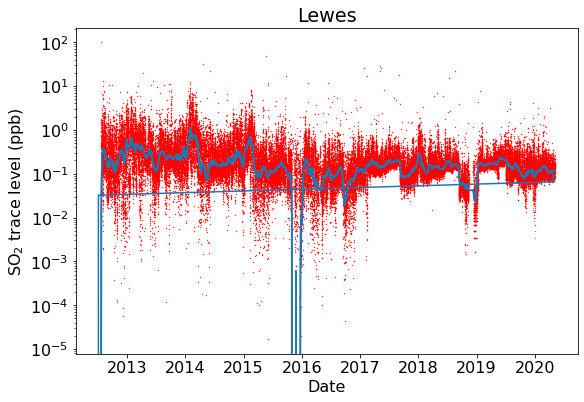

In [89]:
Lewes_SO2 = airdata[(airdata['STA_StationName'] == 'Lewes') & \
                    (airdata['MOT_MonitorName'] == 'SO2 Trace Level')]

plt.figure(figsize=(9,6))
plt.semilogy(Lewes_SO2['ParamValue'], 'r.', markersize=0.5, label='original data')
plt.plot(Lewes_SO2['ParamValue'].rolling(500, min_periods=1, center=True).median(), label='')
plt.xlabel('Date')
plt.ylabel(r"SO$_2$ trace level (ppb)")
plt.title('Lewes')

In [0]:
dt = Lewes_SO2.index.shift(periods=1, freq='s') - Lewes_SO2.index

In [0]:
dt = compute_deltas(Lewes_SO2)


In [87]:
nanmin(dt)/(24*3600), nanmax(dt)/(24*3600), nanmedian(dt)

(-2849.7083333333335, 29.833333333333332, 3600.0)

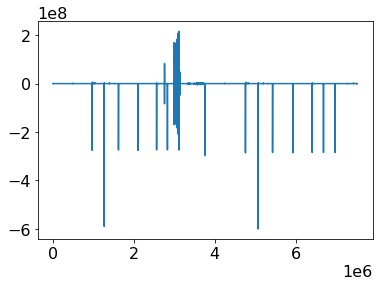

In [80]:
dt.plot()

In [0]:
def compute_deltas(df):

    import datetime as dt
    import pytz
    datestamps=pd.Series(df.index)
    datestamps=(datestamps-dt.datetime(1970,1,1, 0, 0, 0, 0)).dt.total_seconds()
    delta_t=(datestamps[1:]-datestamps.shift(1)[:-1])
    return delta_t

#### Select and plot ozone concentrations measured at the Brandywine Creek State Park station

Text(0.5, 1.0, 'Brandywine Creek State Park')

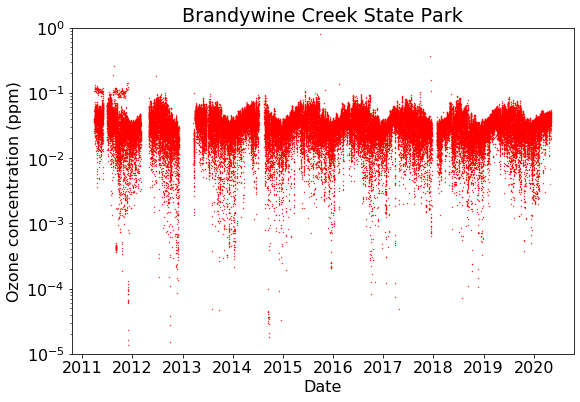

In [0]:
Brandywine_ozone = airdata[(airdata['STA_StationName'] == 'Brandywine Creek State Park') & \
                    (airdata['MOT_MonitorName'] == 'Ozone')]

plt.figure(figsize=(9,6))
plt.semilogy(Brandywine_ozone['Date_Time'], Brandywine_ozone['ParamValue'], 'r.', markersize=0.5)
plt.ylim([1e-5,1])
plt.xlabel('Date')
plt.ylabel('Ozone concentration (ppm)')
plt.title('Brandywine Creek State Park')